# NOCD

In [1]:
import os
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from tqdm import tqdm
%matplotlib inline

from components.utils import load_edgelist_graph,load_ordered_adjlist_graph
from components.evaluation import modularity, symmetric_matrix_modularity

torch.set_default_tensor_type(torch.cuda.FloatTensor)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 1、Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `np.ndarray` of size `[N, D]`

In [2]:
name = 'bio72'
graph_type = 'merged'

graph_adjlist_path  =  './graphs_' + graph_type + '/' + name + '.adjlist'
graph_edgelist_path =  './graphs_' + graph_type + '/' + name + '.edgelist'
# X directly bio72
X_path = './features/' + 'bio72' + '.txt' # only bio72, dpwk 0.71 to 0.68
X_bio72 = np.loadtxt( X_path, dtype=float)
X_embd_path = './features/' + name + '.txt' # only dpwk,  0.71 to 0.72
X_embd = np.loadtxt( X_path, dtype=float)
if name == 'bio72':
    X = X_bio72
else:
    X = np.concatenate((X_bio72,X_embd),axis=1) # order1、2 together(17) 0.7279
G_nx = load_ordered_adjlist_graph( graph_adjlist_path )
A = load_edgelist_graph(graph_edgelist_path)
N, D = X.shape
print('x shape:{} * {}'.format(N, D))

100%|██████████| 968659/968659 [00:08<00:00, 118224.40it/s]


G nodes 25023,edges 993682 with self-loops read already
x shape:25023 * 72


### Hyperparameters 

In [3]:
n_clusters = 16 #                        # 
hidden_sizes = [512]  #    # [512,1024]               # hidden sizes of the GNN      
weight_decay = 1e-2                   # strength of L2 regularization on GNN weights
feature_ae_deacy =   1e-2               # OTUCD part: strength of auto encoder loss, if 0 then modul 0.68 
dropout = 0.5                         # whether to use dropout     0.5
batch_norm = True                     # whether to use batch norm
lr = 1e-3                             # learning rate
max_epochs = 1000                     # number of epochs to train
display_step = 25                     # how often to compute validation loss
balance_loss = True                   # whether to use balanced loss
stochastic_loss = True                # whether to use stochastic or full-batch training
batch_size = 20000                    # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [4]:
'''customized global parameters'''
# hidden_sizes_list = [ [128,128,128,128] ] 

'''global result records'''
epoch_results = []
full_loss_results = []
eval_results = []

'''work'''
for idx in tqdm(range(1)):
    pass
# gnn_model_train_eval(0)

100%|██████████| 1/1 [00:00<00:00, 15087.42it/s]


In [5]:
# def gnn_model_train_eval( idx:int):
'''get customized parameters'''

"""x tensor data"""
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = torch.Tensor(x_norm).cuda().to(torch.float32)
"""gnn model"""
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, n_clusters, batch_norm=batch_norm, dropout=dropout).cuda()
# gnn = nocd.nn.ImprovedGCN(x_norm.shape[1], hidden_sizes, n_clusters, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)
"""train"""
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

x_display_epochs, val_full_loss_list, x_train_epochs, train_loss_list = [],[],[],[]
it = iter( sampler )
# for epoch in tqdm( range( max_epochs+1 ) ):
for epoch in range( max_epochs+1 ) :
    batch = next(it)
    if epoch % display_step == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            z, x_rec = gnn(x_norm, adj_norm)
            Z = F.relu(z)
            val_loss = decoder.loss_full(Z, A)
            x_display_epochs.append( epoch )
            val_full_loss_list.append( val_loss )
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f} ')

            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                stop_epoch = max_epochs
                print(f'Breaking due to early stopping at epoch {epoch}')
                break

    # Training step
    gnn.train()
    opt.zero_grad()
    z, x_rec = gnn(x_norm, adj_norm)
    Z = F.relu(z)
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    # print(f'Epoch {epoch:4d}, loss.full = {loss:.4f} ')
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss += feature_ae_deacy * F.mse_loss(x_norm, x_rec)
    x_train_epochs.append( epoch )
    train_loss_list.append( loss )
    loss.backward()
    opt.step()

'''evaluate'''
z, x_rec = gnn(x_norm, adj_norm)
Z_pred = F.relu(z)
# Z_pred = Z.cpu().detach().numpy() > thresh 
Z_pred = np.argmax(Z_pred.cpu().detach().numpy(), 1)
# model_saver.restore()
score = symmetric_matrix_modularity(G_nx, Z_pred)
# print(f'\nFinal symmetric_matrix_modularity = {:.8f}'.format(score))  
'''record'''
epoch_results.append(x_train_epochs[-1])
full_loss_results.append(val_full_loss_list[-1])
eval_results.append(score)
'''free'''
torch.cuda.empty_cache()
'''show parameters and results'''
print('index:{}'.format(idx),end='\t')
print('epoch_result:{}'.format(epoch_results[idx]),end='\t')
print('full_loss_results:{}'.format(full_loss_results[idx]),end='\t')
print('eval_results:{}'.format(eval_results[idx]))


Epoch    0, loss.full = 1.2775 
Epoch   25, loss.full = 0.4315 
Epoch   50, loss.full = 0.3629 
Epoch   75, loss.full = 0.3437 
Epoch  100, loss.full = 0.3362 
Epoch  125, loss.full = 0.3381 
Epoch  150, loss.full = 0.3367 
Epoch  175, loss.full = 0.3305 
Epoch  200, loss.full = 0.3288 
Epoch  225, loss.full = 0.3272 
Epoch  250, loss.full = 0.3241 
Epoch  275, loss.full = 0.3228 
Epoch  300, loss.full = 0.3171 
Epoch  325, loss.full = 0.3160 
Epoch  350, loss.full = 0.3141 
Epoch  375, loss.full = 0.3168 
Epoch  400, loss.full = 0.3146 
Epoch  425, loss.full = 0.3142 
Epoch  450, loss.full = 0.3177 
Epoch  475, loss.full = 0.3124 
Epoch  500, loss.full = 0.3126 
Epoch  525, loss.full = 0.3112 
Epoch  550, loss.full = 0.3112 
Epoch  575, loss.full = 0.3114 
Epoch  600, loss.full = 0.3094 
Epoch  625, loss.full = 0.3088 
Epoch  650, loss.full = 0.3108 
Epoch  675, loss.full = 0.3093 
Epoch  700, loss.full = 0.3098 
Epoch  725, loss.full = 0.3085 
Epoch  750, loss.full = 0.3083 
Epoch  7

100%|██████████| 25023/25023 [03:18<00:00, 125.91it/s]


index:0	epoch_result:1000	full_loss_results:0.3060242533683777	eval_results:0.5470786055160113


## -------------------------------


```
hidden_sizes_list = []
first_hidden_list = [128,256,512,1024]
second_hidden_list = [128,256,512,1024]
third_hidden_list = [128,256,512,1024]
i, j = 3, 1
front_list = [ first_hidden_list[i], second_hidden_list[j] ]
for k in range( len(third_hidden_list) ):
    temp_list = front_list.copy()
    temp_list.append(third_hidden_list[k])
    hidden_sizes_list.append(temp_list)
```

```
watch loss in train function
print(gnn)
for i in range(len( x_display_epochs )):
    print('epoch {:4d},full_loss:{:6f}'.format( x_display_epochs[i], 
        val_full_loss_list[i] ) )
```

## 2、Analyzing the results

Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

### Visualize the adjacency matrix sorted by the communities

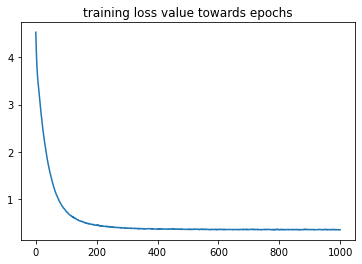

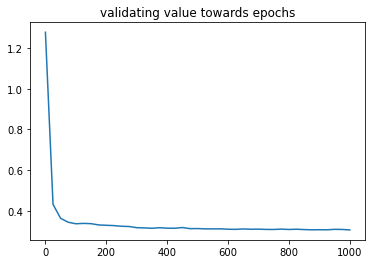

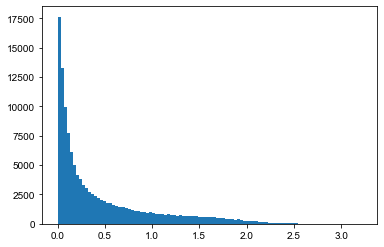

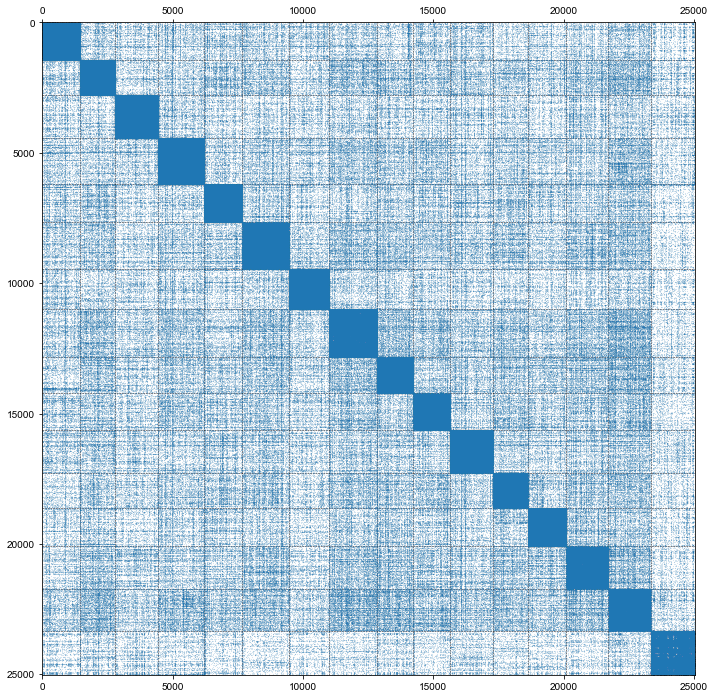

In [6]:

# 损失函数随迭代次数变化
plt.plot(x_train_epochs, train_loss_list, label='train_loss_list')
plt.title('training loss value towards epochs')
plt.show()

plt.title('validating value towards epochs')
plt.plot(x_display_epochs, val_full_loss_list, label='val_full_loss_list')
plt.show()

plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

plt.figure(figsize=[12, 12])
o = np.argsort(Z_pred)
nocd.utils.plot_sparse_clustered_adjacency(A, n_clusters, Z_pred, o, markersize=0.05)


```
# Sizes of detected communities
print(Z_pred.sum(0))
```

### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

```
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')
```

```
### Ground truth communities & Predicted communities
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.
```